# Context: 
#### Construct, Analyze and publish  a dataset of monthly traffic (page views) on English Wikipedia and make it fully reproducible using best practices for open scientific research.

Refer [github Harikc data-512-a1](https://github.com/HarikcUW/data-512-a1/tree/main) for data and additional details. Get complete project if you want to use processed data.


In [1]:
# Import necessary librarires
import json
import requests
import pandas as pd
import numpy as np
from matplotlib.axis import Axis  
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import os
ospath = os.path.abspath("__file__")
currentDir = os.path.dirname(ospath)
data_raw_path = currentDir + '\\data_raw\\'
data_final_path =currentDir + '\\data_final\\'

print("data_raw_path:", data_raw_path)
print("data_final_path:", data_final_path)

data_raw_path: C:\UW\512\data-512-a1\src\data_raw\
data_final_path: C:\UW\512\data-512-a1\src\data_final\


##  Step 1: Data acquisition


### Data source details:
* Wikipedia page traffic is available to public using [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API)
   * Data is available from December 2007, and exposed using 2 APIs
   * Legacy Pagecounts API:
        * Documentation: [Analytics/AQS/Legacy Pagecounts](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts)
        * API endpoint:[Wikimedia REST API-Legacy Pagecounts](https://wikimedia.org/api/rest_v1/#/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end)
        * Data availability: December 2007 to July 2016
   * Pageviews API: 
        * Documentation: [Analytics/AQS/Pageviews](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews)
        * API endpoint: [Wikimedia REST API-Pageviews](https://wikimedia.org/api/rest_v1/#/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)
        * Data availability:July 2015 to last month

## If API end points doesn't work or you want to use raw data available in this project, you can skip get data using API and directly move to "Get raw data from project". Also you can skip data acqusion step and directly use final data from project.

# Get data using Wikimedia API endpoints:

In [3]:
# define end points
endpoint_pagecounts = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

### Set parameters to read data from various query type
* Legacy Pagecounts API parameters:
    * **project:** we get data from "en.wikipedia.org"
    * **access-site:** Get desktop-site & mobile-site access data
    * **granularity:** Get monthly aggregated data
    * **start:** get data from July 2007. Format should be YYYYMMDDHH
    * **end:** get data till July 2016. Monthly granular data excludes the given date, so we have to set next month first date to get data up to a given month, so in this case we will set 2016080100
    
* Pageviews API parameters:
    * **project:** we get data from "en.wikipedia.org"
    * **agent:** We are interested at user (organic page views). other options are: all-agents, spider, automated
    * **access:** Get desktop, mobile-app & mobile-web access data
    * **granularity:** Get monthly aggregated data
    * **start:** get data from July 2015. Format should be YYYYMMDDHH
    * **end:** get data till Sep 2021, so we will set 2021100100

** In Pageviews API we have additional parameter "agent" and "access-site" is renamed as "access"

** Pageviews API returns mobile-web & mobile-app data separately, so we have to combine to get overall mobile data


In [4]:
# Set parameters to gettingdata from legacy pagecounts data 
params_pagecounts_desktop_site = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007010100",
                 "end" : "2016080100" #In monthly granularity, end timestamp is exclusive.
                    }

params_pagecounts_mobile_site = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007010100",
                 "end" : "2016080100"
                    }

# Set parameters to gettingdata from pageviews data 
params_pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user", # Fileter User data
                    "granularity" : "monthly",
                    "start" : "20150701",
                    "end" : '20211001'
                        }

params_pageviews_mobile_app = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "20150701",
                    "end" : '20211001'
                        }

params_pageviews_mobile_web = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "20150701",
                    "end" : '20211001'
                        }

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/harikc',
    'From': 'harikc@uw.edu'
}

## Define function to call API and return result in json format
* define api_call function which takes input arguments API endpoint and necessary parameter 
* conevert API response to json
* return response

In [5]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

### Using api_call function get data from Legacy pagecounts and Pageviews endpoints
* Use api_call to get data for various access sites/methods(desktop, mobile) from both legacy & current endpoints

In [6]:
monthly_pagecounts_desktop_site = api_call(endpoint_pagecounts, params_pagecounts_desktop_site)
monthly_pagecounts_mobile_site = api_call(endpoint_pagecounts, params_pagecounts_mobile_site)
monthly_pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
monthly_pageviews_mobile_app = api_call(endpoint_pageviews, params_pageviews_mobile_app)
monthly_pageviews_mobile_web = api_call(endpoint_pageviews, params_pageviews_mobile_web)

# Check result and identify data elements

In [7]:
monthly_pagecounts_mobile_site

{'items': [{'project': 'en.wikipedia',
   'access-site': 'mobile-site',
   'granularity': 'monthly',
   'timestamp': '2014100100',
   'count': 3091546685},
  {'project': 'en.wikipedia',
   'access-site': 'mobile-site',
   'granularity': 'monthly',
   'timestamp': '2014110100',
   'count': 3027489668},
  {'project': 'en.wikipedia',
   'access-site': 'mobile-site',
   'granularity': 'monthly',
   'timestamp': '2014120100',
   'count': 3278950021},
  {'project': 'en.wikipedia',
   'access-site': 'mobile-site',
   'granularity': 'monthly',
   'timestamp': '2015010100',
   'count': 3485302091},
  {'project': 'en.wikipedia',
   'access-site': 'mobile-site',
   'granularity': 'monthly',
   'timestamp': '2015020100',
   'count': 3091534479},
  {'project': 'en.wikipedia',
   'access-site': 'mobile-site',
   'granularity': 'monthly',
   'timestamp': '2015030100',
   'count': 3330832588},
  {'project': 'en.wikipedia',
   'access-site': 'mobile-site',
   'granularity': 'monthly',
   'timestamp': '

In [8]:
monthly_pageviews_mobile_app

{'items': [{'project': 'en.wikipedia',
   'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'timestamp': '2015070100',
   'views': 109624146},
  {'project': 'en.wikipedia',
   'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'timestamp': '2015080100',
   'views': 109669149},
  {'project': 'en.wikipedia',
   'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'timestamp': '2015090100',
   'views': 96221684},
  {'project': 'en.wikipedia',
   'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'timestamp': '2015100100',
   'views': 94523777},
  {'project': 'en.wikipedia',
   'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'timestamp': '2015110100',
   'views': 94353925},
  {'project': 'en.wikipedia',
   'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'timestamp': '2015120100',
   'views': 99438956},
  {'project': 'en.wikipedia',
   'a

## Save Json Data
* save the raw results into 5 separate JSON source data files
* File name format: apiname_accesstype_firstmonth-lastmonth.json. 
* For example File pagecounts_desktop-site_200712-202108.json will contain monthly page views for devices requesting the desktop versions of pages 

In [9]:

os.makedirs(os.path.dirname(data_raw_path), exist_ok=True) 

with open(data_raw_path + 'pagecounts_desktop-site_200712-201607.json', 'w', encoding='utf-8') as file:
    json.dump(monthly_pagecounts_desktop_site,file,ensure_ascii=False, indent=3)

with open(data_raw_path +'pagecounts_mobile-site_200712-201607.json', 'w', encoding='utf-8') as file:
    json.dump(monthly_pagecounts_mobile_site,file,ensure_ascii=False, indent=3)

with open(data_raw_path +'pageviews_desktop_201507-202109.json', 'w', encoding='utf-8') as file:
    json.dump(monthly_pageviews_desktop,file,ensure_ascii=False, indent=3)

with open(data_raw_path +'pageviews_mobile-app_201507-202109.json', 'w', encoding='utf-8') as file:
    json.dump(monthly_pageviews_mobile_app,file,ensure_ascii=False, indent=3)

with open(data_raw_path +'pageviews_mobile-web_201507-202109.json', 'w', encoding='utf-8') as file:
    json.dump(monthly_pageviews_mobile_web,file,ensure_ascii=False, indent=3)


## If source API's are not available or difficult to access, you can access data from current project folder

# Get raw data from project 

In [10]:
with open(data_raw_path + 'pagecounts_desktop-site_200712-201607.json',) as file:
    monthly_pagecounts_desktop_site = json.load(file)
    
with open(data_raw_path + 'pagecounts_mobile-site_200712-201607.json',) as file:
    monthly_pagecounts_mobile_site = json.load(file)
    
with open(data_raw_path + 'pageviews_desktop_201507-202109.json',) as file:
    monthly_pageviews_desktop = json.load(file)
    
with open(data_raw_path + 'pageviews_mobile-app_201507-202109.json',) as file:
    monthly_pageviews_mobile_app = json.load(file)
    
with open(data_raw_path + 'pageviews_mobile-web_201507-202109.json',) as file:
    monthly_pageviews_mobile_web = json.load(file)

# Step 2: Data processing
* Parse Json object and get necessary data elements (timestamp & count)
* Extract year and month from timestamp

In [11]:
df_monthly_pagecounts_desktop = pd.DataFrame([ [item['timestamp'],item['count'] ] for item in monthly_pagecounts_desktop_site['items']]
            ,columns = ['timestamp','pagecount_desktop_views']
            )
df_monthly_pagecounts_desktop['yyyyMM'] = df_monthly_pagecounts_desktop['timestamp'].str[:6]
df_monthly_pagecounts_desktop = df_monthly_pagecounts_desktop[['yyyyMM','pagecount_desktop_views']]

In [12]:
df_monthly_pagecounts_mobile = pd.DataFrame([ [item['timestamp'],item['count'] ] for item in monthly_pagecounts_mobile_site['items']]
            ,columns = ['timestamp','pagecount_mobile_views']
            )
df_monthly_pagecounts_mobile['yyyyMM'] = df_monthly_pagecounts_mobile['timestamp'].str[:6]
df_monthly_pagecounts_mobile = df_monthly_pagecounts_mobile[['yyyyMM','pagecount_mobile_views']]

In [13]:
df_monthly_pageviews_desktop = pd.DataFrame([ [item['timestamp'],item['views'] ] for item in monthly_pageviews_desktop['items']]
            ,columns = ['timestamp','pageview_desktop_views']
            )
df_monthly_pageviews_desktop['yyyyMM'] = df_monthly_pageviews_desktop['timestamp'].str[:6]
df_monthly_pageviews_desktop = df_monthly_pageviews_desktop[['yyyyMM','pageview_desktop_views']]

In [14]:
df_monthly_pageviews_mobile_app = pd.DataFrame([ [item['timestamp'],item['views'] ] for item in monthly_pageviews_mobile_app['items']]
            ,columns = ['timestamp','pageview_mobile_app_views']
            )
df_monthly_pageviews_mobile_app['yyyyMM'] = df_monthly_pageviews_mobile_app['timestamp'].str[:6]
df_monthly_pageviews_mobile_app = df_monthly_pageviews_mobile_app[['yyyyMM','pageview_mobile_app_views']]

In [15]:
df_monthly_pageviews_mobile_web = pd.DataFrame([ [item['timestamp'],item['views'] ] for item in monthly_pageviews_mobile_web['items']]
            ,columns = ['timestamp','pageview_mobile_web_views']
            )
df_monthly_pageviews_mobile_web['yyyyMM'] = df_monthly_pageviews_mobile_web['timestamp'].str[:6]
df_monthly_pageviews_mobile_web = df_monthly_pageviews_mobile_web[['yyyyMM','pageview_mobile_web_views']]

## Prepare final processed data set

* Generate dummy dataset with all months between 2007-12 and 2021-09
* Combine all data sets to get final data set
* Set Pageviews/Pagecounts value to 0 if value is not available
* prepare final data set with required attributes

In [45]:
df_months = pd.DataFrame(pd.date_range('2007-12-01','2021-09-30', 
              freq='MS').strftime("%Y%m"),columns = ['yyyyMM'])

df_final = df_months.join(df_monthly_pagecounts_desktop.set_index('yyyyMM'), on='yyyyMM', how ='left') \
    .join(df_monthly_pagecounts_mobile.set_index('yyyyMM'), on='yyyyMM', how ='left') \
    .join(df_monthly_pageviews_desktop.set_index('yyyyMM'), on='yyyyMM', how ='left') \
    .join(df_monthly_pageviews_mobile_app.set_index('yyyyMM'), on='yyyyMM', how ='left') \
    .join(df_monthly_pageviews_mobile_web.set_index('yyyyMM'), on='yyyyMM', how ='left') \
    .fillna(0)

df_final['pageview_mobile_views'] = df_final['pageview_mobile_app_views'] + df_final['pageview_mobile_web_views']
df_final['pagecount_all_views'] = df_final['pagecount_desktop_views'] + df_final['pagecount_mobile_views']
df_final['pageview_all_views'] = df_final['pageview_desktop_views'] + df_final['pageview_mobile_views']
df_final['year'] = df_final['yyyyMM'].str[:4] 
df_final['month'] = df_final['yyyyMM'].str[4:6]

df_final['pagecount_all_views'] = df_final['pagecount_all_views'] #.astype(pd.np.int64)
df_final['pagecount_desktop_views'] = df_final['pagecount_desktop_views'] #.astype(pd.np.int64)
df_final['pagecount_mobile_views'] = df_final['pagecount_mobile_views'] #.astype(pd.np.int64)
df_final['pageview_all_views'] = df_final['pageview_all_views'] #.astype(pd.np.int64)
df_final['pageview_desktop_views'] = df_final['pageview_desktop_views'] #.astype(pd.np.int64)
df_final['pageview_mobile_views'] = df_final['pageview_mobile_views'] #.astype(pd.np.int64)

df_final = df_final[['year','month','pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views','pageview_all_views','pageview_desktop_views','pageview_mobile_views']]
df_final.dtypes

year                        object
month                       object
pagecount_all_views        float64
pagecount_desktop_views    float64
pagecount_mobile_views     float64
pageview_all_views         float64
pageview_desktop_views     float64
pageview_mobile_views      float64
dtype: object

## Save processed final data in csv format
* Save proceed data set in /data-final/ folder
* Users can us this file directly for data analysis/visualization   

In [17]:
os.makedirs(os.path.dirname(data_final_path), exist_ok=True) 
df_final.to_csv( data_final_path + 'en-wikipedia_traffic_200712-202108.csv', sep='\t', index = False)

## Read final csv file if you like to start analysis using processed data

In [18]:
df_final = pd.read_csv(data_final_path + 'en-wikipedia_traffic_200712-202108.csv', sep='\t', dtype = {'year': object
                                                                                                      ,'month': object
                                                                                                      ,'pagecount_all_views': pd.np.int64
                                                                                                      ,'pagecount_desktop_views': pd.np.int64
                                                                                                      ,'pagecount_mobile_views': pd.np.int64
                                                                                                      ,'pageview_all_views': pd.np.int64
                                                                                                      ,'pageview_desktop_views': pd.np.int64
                                                                                                      ,'pageview_mobile_views': pd.np.int64
                                                                                                      }
                                                                                                      )

df_final.dtypes 

year                       object
month                      object
pagecount_all_views         int64
pagecount_desktop_views     int64
pagecount_mobile_views      int64
pageview_all_views          int64
pageview_desktop_views      int64
pageview_mobile_views       int64
dtype: object

## Step 3: Analysis

* Create a time series graph using final data set
* Plot mobile traffic, desktop traffic and combined traffic
* Show Legacy Pagecounts and current Pageviews
* Show Legends
* Add Title & axis labels
* Format Y-axis title (convert to billin and suffix number with B)
* Use **--** to show All up numbers so that we can view both all up and specific category when there is values for only one category. Example, till 2014, we have only desktop page counts, so pagecount_all_views & pagecount_desktop_views will be same. 

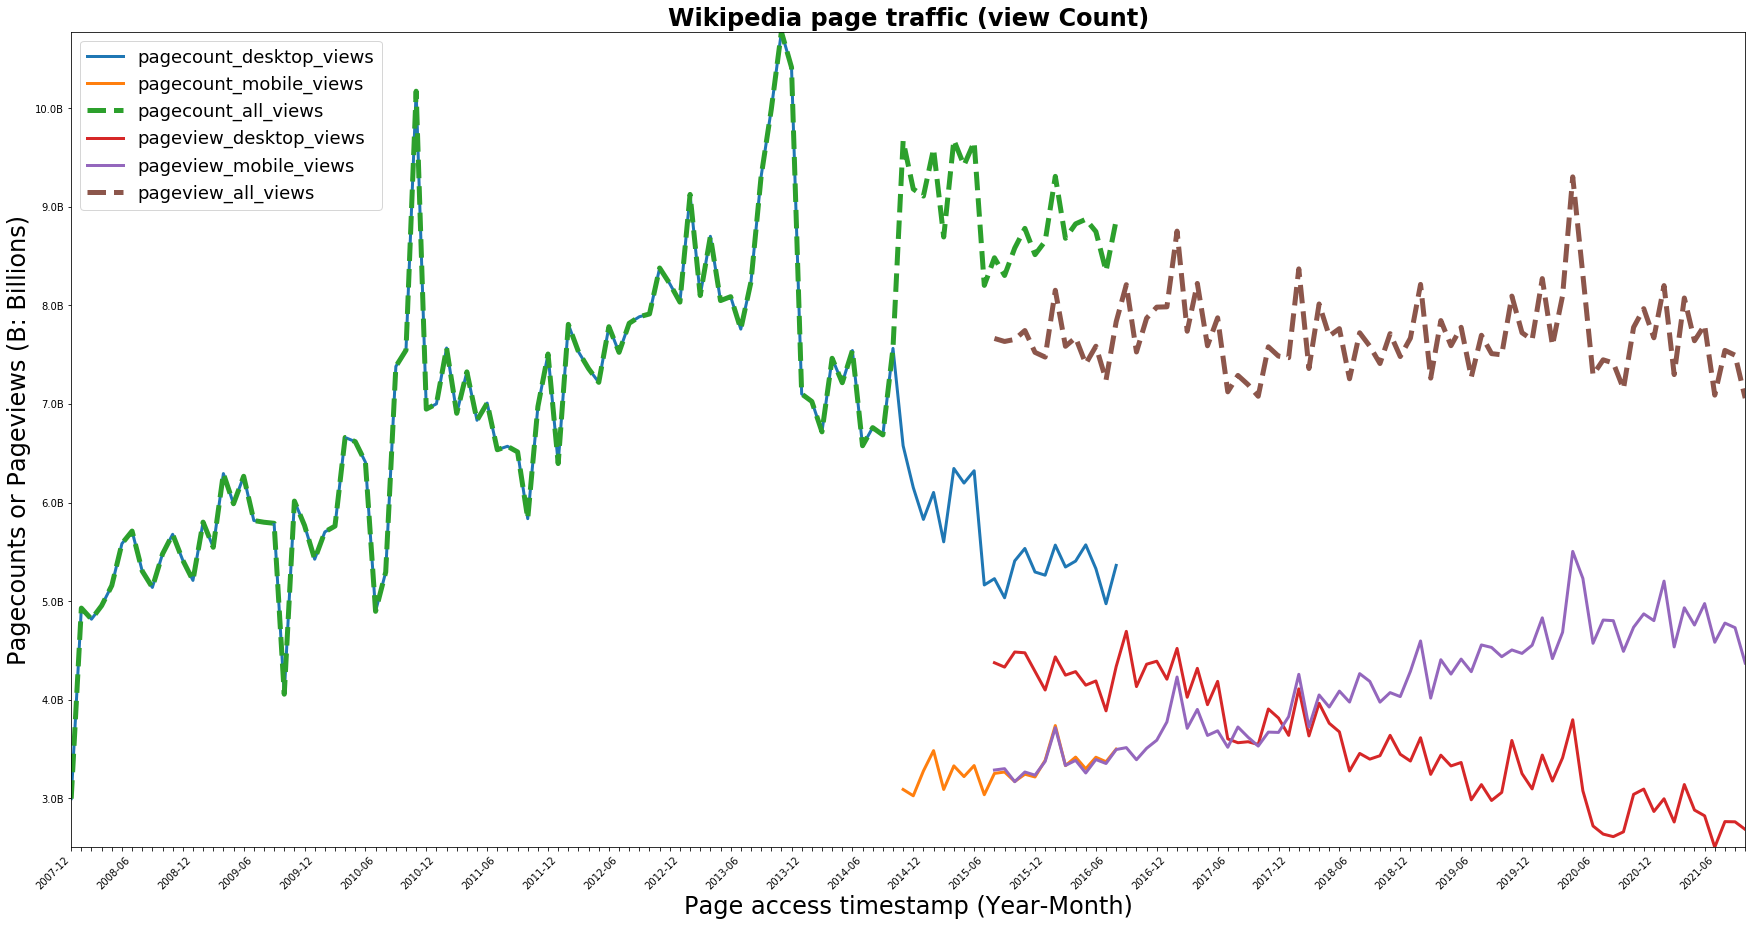

In [99]:
df_final['Year-Month'] = df_final['year']  + "-" + df_final['month'] 
df_final.replace(0, np.nan, inplace=True)
plt.figure(figsize=(30,15))
plt.plot(df_final['Year-Month'], df_final['pagecount_desktop_views'],linewidth = 3 )
plt.plot(df_final['Year-Month'], df_final['pagecount_mobile_views'],linewidth = 3 )
plt.plot(df_final['Year-Month'], df_final['pagecount_all_views'],'--',linewidth = 5 )

plt.plot(df_final['Year-Month'], df_final['pageview_desktop_views'],linewidth = 3 )
plt.plot(df_final['Year-Month'], df_final['pageview_mobile_views'],linewidth = 3 )
plt.plot(df_final['Year-Month'], df_final['pageview_all_views'],'--',linewidth = 5 )

ax = plt.gca()
#Format Pageview count to show the value in Billions instead of scientific notation
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:}B'.format(round(x/1000000000, 1))))
#Show evry 6 element in X-axix label
[xaxisticks.set_visible(False) for (n,xaxisticks) in enumerate(ax.xaxis.get_ticklabels( minor=False)) if n % 6 != 0]

plt.margins(0)
# SShow X-axis label in 45 degrees
plt.xticks(rotation=45,ha='right')
plt.title("Wikipedia page traffic (view Count)",fontweight="bold",fontsize=24)
plt.xlabel("Page access timestamp (Year-Month)",fontsize=24)
plt.ylabel("Pagecounts or Pageviews (B: Billions)",fontsize=24);
plt.legend(title = "Page views by device type",fontsize=24)
#plt.grid()
plt.legend(fontsize=18)
plt.show()

# Observations:
* We have overlap time between Legacy Pagecounts and Pageviews (between 2014-10 and 2016-07)
* Legacy Pagecounts volums is higher than Pageviews count
* Due to high mobile usage and apps availability, mobile pageviews are increasing and desktop pageviews are going down
* Pagecount_all_views and Pagecount_desktop_vies are overlaped befoe 2014/10. We can see only one line in grap as they overlap. It is due to no data for Pagecount_mobile_views.